/var/folders/v5/tz7wp_cs40906rkn0nqpb_vm0000gn/T/ipykernel_11411/433942319.py:69: RuntimeWarning: divide by zero encountered in log
  AA[it] = np.log(np.max(np.abs(psi)))
/var/folders/v5/tz7wp_cs40906rkn0nqpb_vm0000gn/T/ipykernel_11411/433942319.py:70: RuntimeWarning: divide by zero encountered in log
  AR[it] = np.log(np.max(np.abs(np.real(psi))))


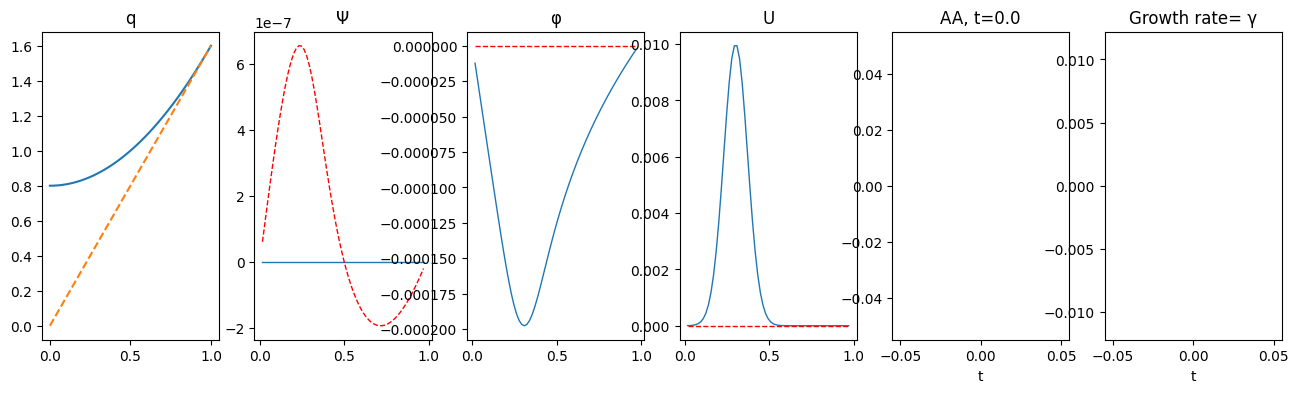

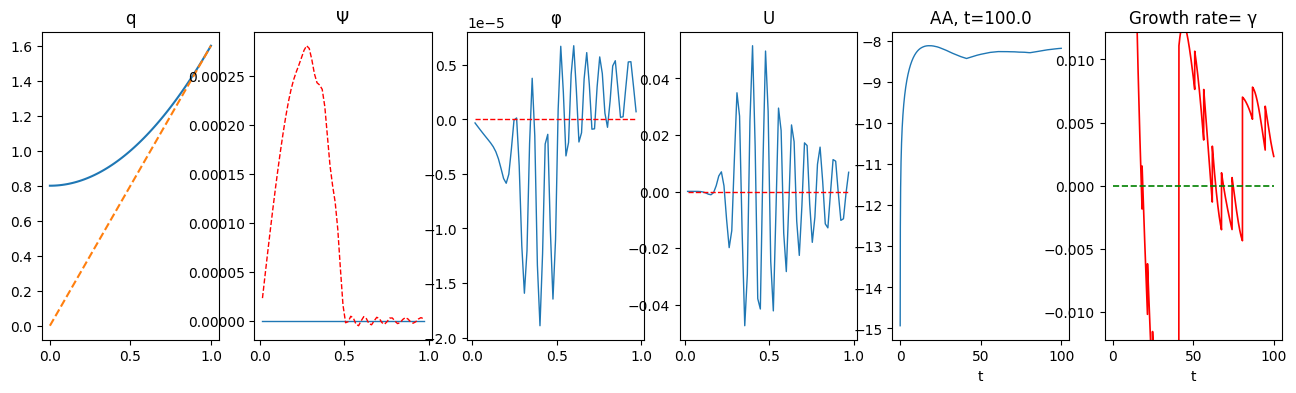

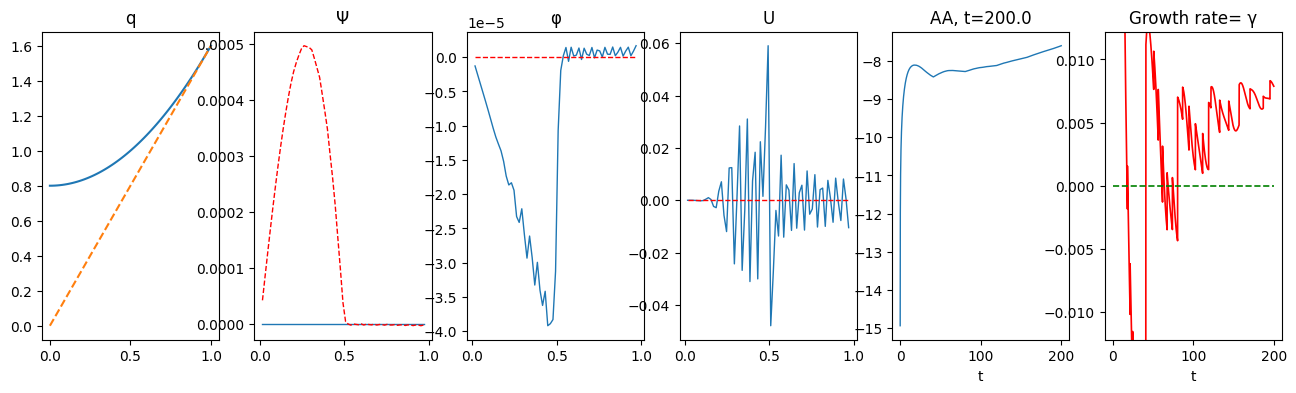

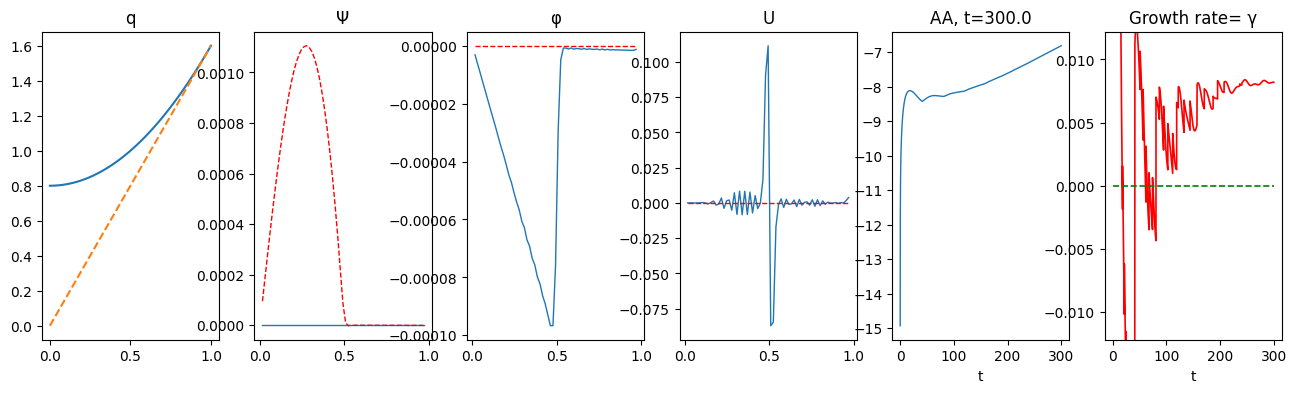

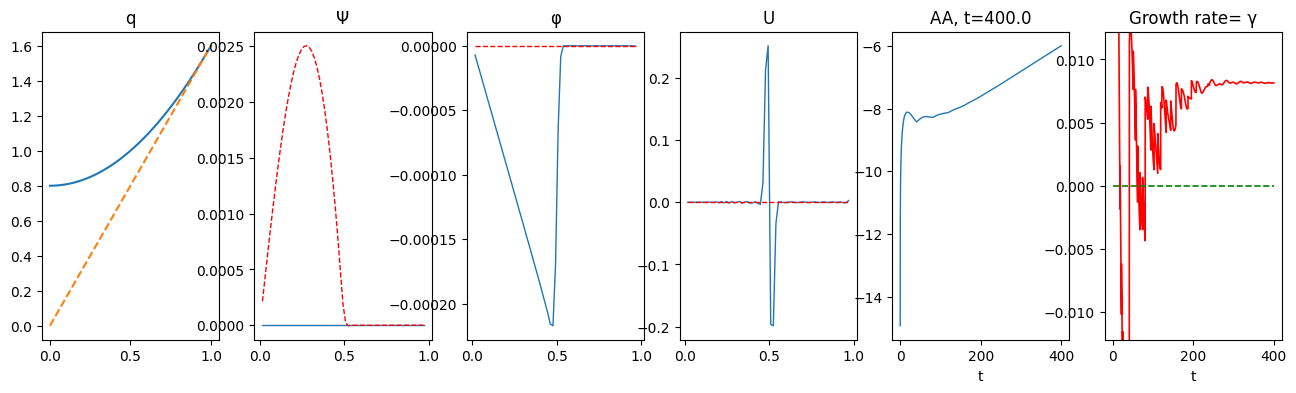

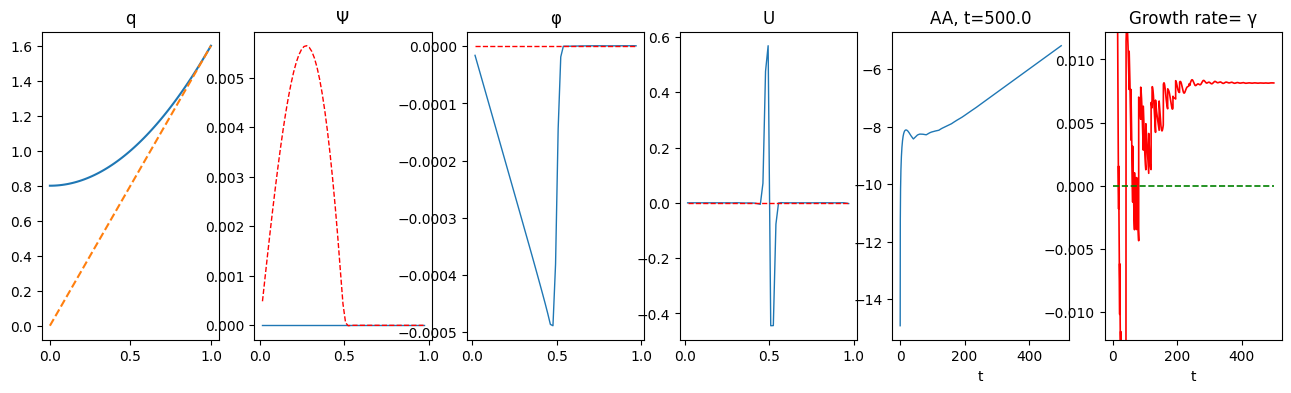

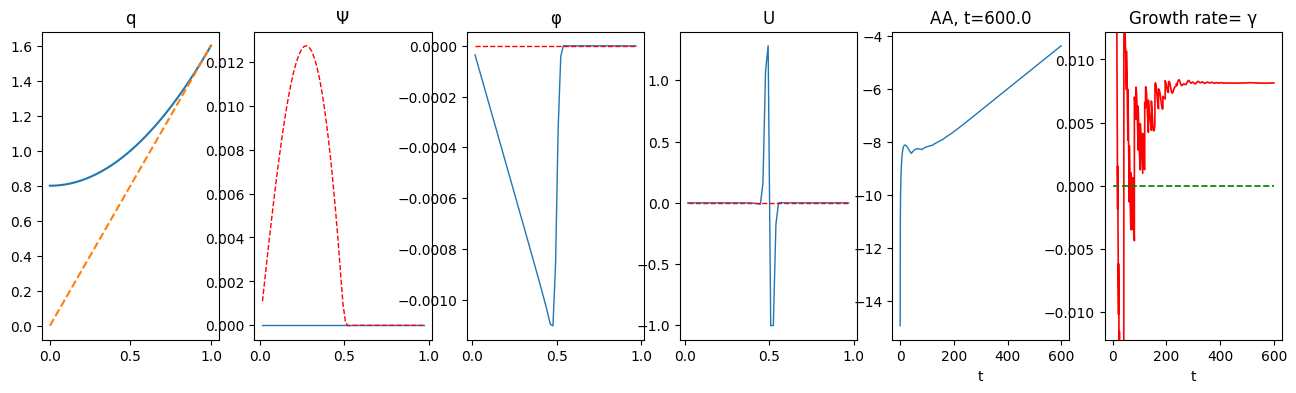

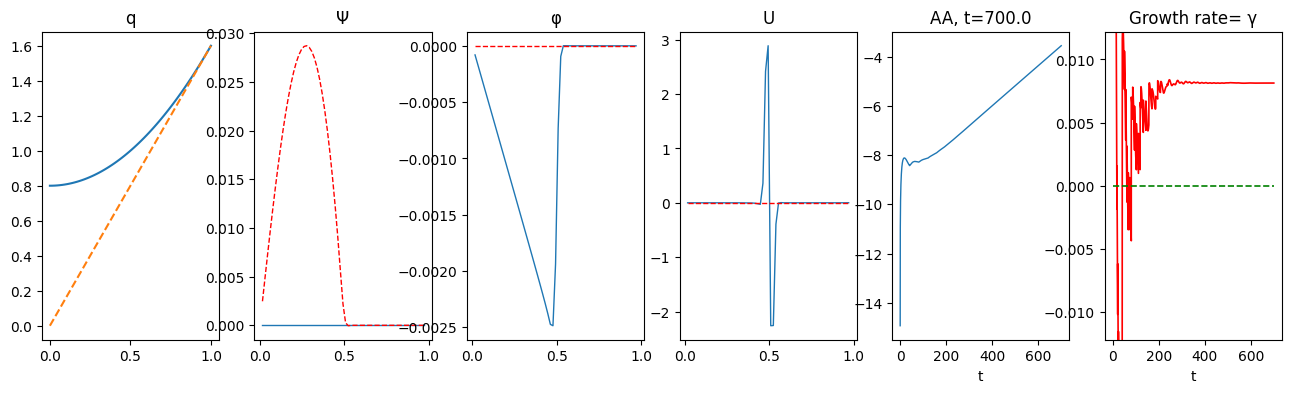

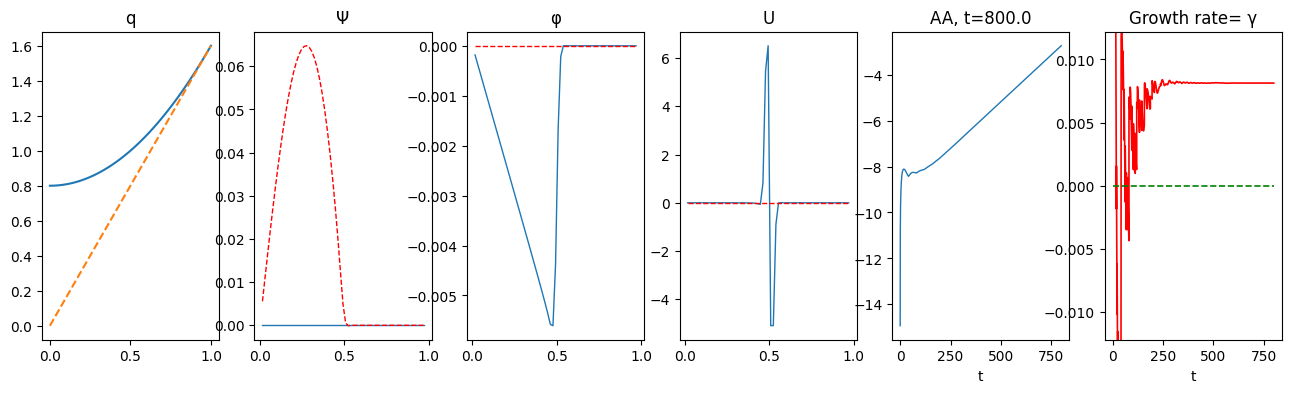

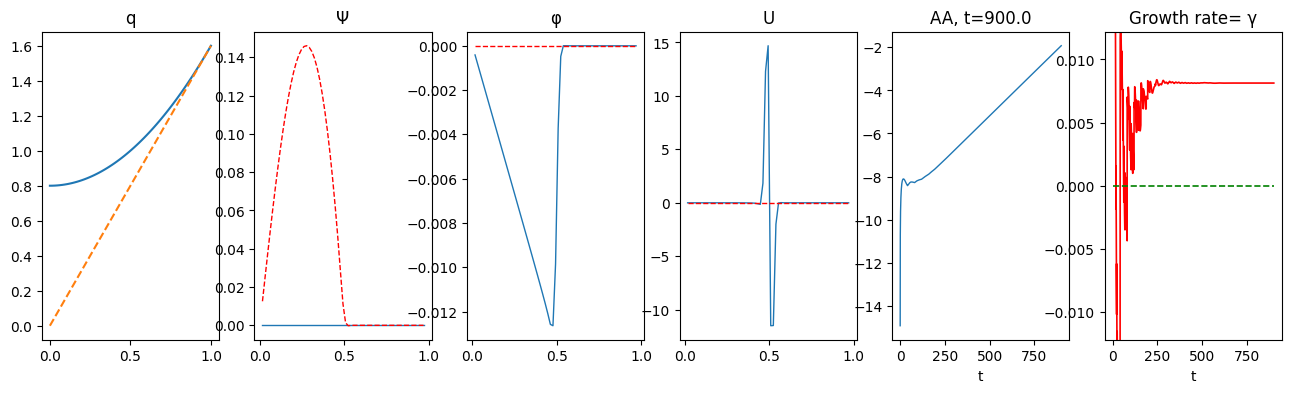

In [14]:
# Time-dependent Reduced resistive MHD solver (RMS) in cylindrical geometry (in the limit of zero plasma beta)
# Tool - 
# 1. TBA
# 2. 
# 3. 
#Ref. 
# 1. 
# 2. 


import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.sparse import diags
import scipy.sparse as spsp
from scipy.sparse.linalg import spsolve

cntplt = 0 # Countour plot (1 ='Y' or 0 = 'N')
nt = 100000
dt = 0.01
NN = 2**6
r = np.linspace(0, 1, NN+2)
dr = r[1] - r[0]

# Initial profiles safety factor 'q', shear 's', resistivity '\eta', and viscosity '\nu' as a function of radial co-ordinate 'r' 
q0 = 0.8
q1 = 0
q2 = 0.8
q = q0 + q1*r + q2*r**2
qp = q1 + 2*q2*r
qpp = 2*q2
s = r*qp/q
sp = (r*q*qpp + q*qp - qp**2*r) / q**2
eta = 1e-6 + 0*r
nu = 1e-6
m = 1
n = 1

#Discretization based on second-order central and first order forward difference schemes
rr = r[1:NN]  
qj = q[1:NN]
sj = s[1:NN]
spj = sp[1:NN]
etaj = eta[1:NN]

rhojp = (1/dr**2 + 1/(2*rr*dr))   # rho_j[+1]
rhoj0 = 0.0*rr - 2/dr**2          # rho_j[0]
rhojm = (1/dr**2 - 1/(2*rr*dr))   # rho_j[-1]

psi = 0.0 * np.exp(-(rr-0.2)**2 / 0.01)
uu = (1.0 + 0.0j) * 0.01 * np.exp(-((rr - 0.3)** 2) / 0.01)
phi = 0.0*rr

# #Define matrix elements of DI -  tri-diagonal and sparse matrix 

DI = diags([rhoj0 - m**2/rr**2, rhojm[1:], rhojp[:NN-1]], [0, -1, 1], shape=(NN-1,NN-1), dtype=complex)
DI= DI.tocsr()

gamma = np.zeros(nt)
AA = np.zeros(nt)
AR = np.zeros(nt)
t = np.zeros(nt)

gamma[0] = 1

# Solve an time-dependent matrix evaluation for magnetic flux function for current denisty 
# & Electrostatic potentail for vorticity.
for it in range(nt):
    AA[it] = np.log(np.max(np.abs(psi)))
    AR[it] = np.log(np.max(np.abs(np.real(psi))))
    
    if it > 0:
        gamma[it] = (AA[it] - AA[it-1]) / dt
       
    t[it] = (it-1) * dt

    #uu = uu.reshape(-1, 1)

    phi = spsolve(DI, uu.T)
    grad2perppsi = (DI @ psi.T).T
    grad2perpu = (DI @ uu.T).T
    
    RC1 = 1j * (n - m/qj) * phi + etaj * grad2perppsi
    RC2 = 1j * (n - m/qj) * grad2perppsi + nu * grad2perpu - 1j * m / rr * (spj / qj - sj * (sj - 2) / (rr * qj)) * psi
    
    psi = psi + RC1 * dt
    uu = uu + RC2 * dt
    

    if it == nt or it % (nt//10) == 1:
        
        h=plt.figure(figsize=(16,4))

        plt.subplot(1,6,1)
        plt.plot(r,q,r,qp,'--')
        plt.title('q')

        plt.subplot(1,6,2)
        plt.plot(rr, np.real(psi), rr, np.imag(psi), 'r--', linewidth=1)
        plt.title('Ψ')
        
        plt.subplot(1,6,3)
        plt.plot(rr, np.real(phi), rr, np.imag(phi), 'r--', linewidth=1)
        plt.title('φ')
        
        plt.subplot(1,6,4)
        plt.plot(rr, np.real(uu), rr, np.imag(uu), 'r--', linewidth=1)
        plt.title('U')
        
        plt.subplot(1,6,5)
        plt.plot(t[:it-1], AA[:it-1], t[it-1], AR[it-1], 'r--', linewidth=1)
        plt.title('AA, t={}'.format((it-1)*dt))
        plt.xlabel('t')
        
        plt.subplot(1,6,6)
        plt.plot(t[1:it-1], gamma[1:it-1], 'r', [0,t[it]],[0, 0], 'g--', linewidth=1.2)
        plt.title('Growth rate= γ')
        plt.xlabel('t')
        plt.ylim([-0.012198004824249,0.012198004824249])
        
        plt.pause(0.02)
    plt.show()
    
    nta = np.floor(2*nt/3)


    if cntplt==1:
        theta = np.arange(0, 2*np.pi, np.pi/50)
        r, theta = np.meshgrid(rr, theta)
        col, row = r.shape
        psi = np.tile(psi, (col, 1)) * np.exp(-1j * m * theta)
        phi = np.tile(phi, (col, 1)) * np.exp(-1j * m * theta)
        
        U = np.tile(uu, (col, 1)) * np.exp(-1j * m * theta)
        X = r * np.cos(theta)
        Z = r * np.sin(theta)
        
        
        h=plt.figure(figsize= (14,4))
        
        plt.subplot(1,3,1)
        plt.pcolor(X, Z, np.real(psi))
        plt.axis('equal')
        plt.title('\psi, 2D contour')
        plt.colorbar(location='right')
        plt.set_cmap('hsv')
        
        plt.subplot(1,3,2)
        plt.pcolor(X, Z, np.real(phi))
        plt.axis('equal')
        plt.title('\phi, 2D contour')
        plt.colorbar(location='right')
        plt.set_cmap('hsv')

        plt.subplot(1,3,3)
        plt.pcolor(X, Z, np.real(U))
        plt.axis('equal')
        plt.title('U, 2D contour')
        plt.colorbar(location='right')
        plt.set_cmap('hsv')
